In [1]:
from datetime import datetime
# from google.colab import files

from pathlib import Path
from collections import namedtuple
from pprint import pprint

# import psycopg2 as ps
import matplotlib.pyplot as plt
import matplotlib as mpl
plt.style.use('dark_background')
import seaborn as sns
# sns.set_theme(style="whitegrid")
import ipywidgets as widgets
# back end of ipywidgets
from IPython.display import display

import io
import zipfile

import collections
import itertools
import functools
import glob
import operator
import os
import re
import numpy as np
import pandas as pd

from PIL import Image

# skimage
import skimage
import skimage.metrics as skmetrics
from skimage.metrics import peak_signal_noise_ratio as psnr
from skimage.metrics import structural_similarity as ssim
from skimage.metrics import mean_squared_error

from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures

In [2]:
def compute_graph_image_psnr_CR(data_tuples, x_axes, y_axes, subject, colors = sns.color_palette()):   
    # Prepare pairs of attributes to be represented
    # one against the other via scatter plot.
    # x_axes = "bpp;file_size_bits".split(";")
    # y_axes = "psnr;CR".split(";")

    pairs_axes = list(itertools.product(x_axes, y_axes))

    # Settle figure grid.
    axes_list = None
    fig, axes = plt.subplots(len(x_axes), len(y_axes), figsize=(20, 10))
    try:
        axes_list = functools.reduce(operator.iconcat, axes, [])
    except:
        axes_list = axes
        pass

    # Compute graph.
    for ii, (ax, pair_axes) in enumerate(zip(axes_list, pairs_axes)):
        # Prepare data.
        x_axis, y_axis = pair_axes[0], pair_axes[1]
        x = np.array(list(map(lambda item: getattr(item, f"{x_axis}"), data_tuples)))
        y = np.array(list(map(lambda item: getattr(item, f"{y_axis}"), data_tuples)))
        # Create Chart.
        ax.scatter(x, y, marker = 'x', color = colors[ii], label = f'{subject} - {y_axis}')
        # ax.set_xscale('symlog')
        # ax.set_yscale('symlog')
        ax.set_ylabel(f'{y_axis}')
        ax.set_xlabel(f'{x_axis}')
        ax.legend()
        ax.set_title(f'{y_axis.upper()} vs. {x_axis.upper()}')
        pass
    return fig, axes

Image size: (481, 321)


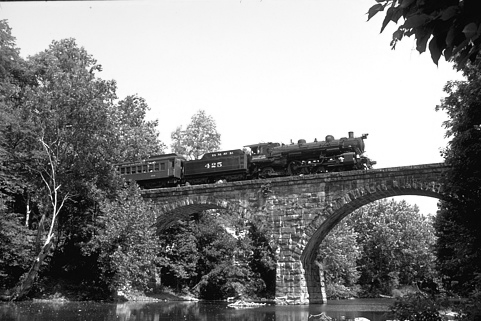

In [3]:
image_file_path = 'test068.png'
im = Image.open(f'{image_file_path}')
print('Image size:', im.size)
im

In [4]:
sidelength = min(im.size)
sidelength

321

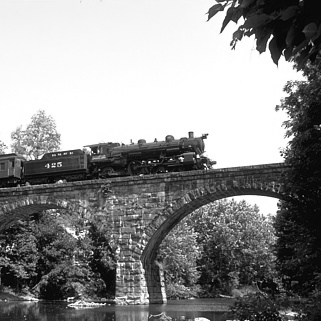

In [5]:
width, height = im.size 

left = width - height
top = 0
right = width
bottom = height

im.crop((left, top, right, bottom))

In [6]:
# im.save(f'{}')

In [7]:
qualities_arr = np.arange(20, 97, dtype = np.int)

In [8]:
qualities_arr

array([20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36,
       37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53,
       54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70,
       71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87,
       88, 89, 90, 91, 92, 93, 94, 95, 96])

In [9]:
left_edges = np.random.randint(0, width - height + 1, size=(100))
top_edges = np.random.randint(0, 10+1, size=(100))
right_edges = np.random.randint(width - 10, width + 1, size=(100))
bottom_edges = np.random.randint(height - 10, height + 1, size=(100))

left_edges

array([ 17,   8, 142, 137,  92,  84,  53,  94,  86, 133,  16,  71,  25,
       117, 157, 142, 158,   6, 101,  42,  64,  93, 121,  86, 110,  69,
        95, 129,  46,  32,  14, 148, 158,  67,   8,  75,  50, 150,  89,
         6, 115,   2, 143,  34,  50, 148,  41,  18, 114, 146, 132, 155,
        14,  27, 142, 160,  97,  40, 142,   4,  10, 139,  33,  87,  55,
        80, 127, 148, 135,  25,  10, 108,  22,  38,  49, 134, 110,  88,
        35, 143, 118,  98,  66,  89,  34,  95,  47, 121, 117,  89, 100,
        13, 105,  24,  40,  60,  90, 133, 149, 129])

In [10]:
edges_list = np.stack((left_edges, top_edges, right_edges, bottom_edges), axis=-1)
edges_list.shape

(100, 4)

In [11]:
WeightsPsnr = collections.namedtuple('WeightsPsnr',['weight','psnr']) 
result_tuples = []
failure_qualities = []
# for edges in edges_list:
for edges in [(left, top, right, bottom)]:
    left, top, right, bottom = list(map(int, edges))
    for quality in qualities_arr:
        try:
            im_tmp = im.crop((left, top, right, bottom))
            im_tmp.save(f'myimg.jpg', quality = int(quality))
            im_jpeg = Image.open('myimg.jpg')
    
            weights = im_jpeg.size[0] * im_jpeg.size[1] * 8
            score = psnr(np.asarray(im_tmp), np.asarray(im_jpeg), data_range=255)
    
            result_tuples.append(WeightsPsnr._make([weights, score]))
        except:
            failure_qualities.append(quality)
        pass
    pass

In [12]:
# Run several trials for JPEG compression.

# Named tuple for creating a record related to
# a trial for compressing the target image.
name_obj = 'WeightsPsnr'
attributes = ['psnr', 'quality', 'file_size_bits', 'bpp', 'width', 'heigth', 'CR']
WeightsPsnr = collections.namedtuple(name_obj, attributes) 

# List used to save results and keep trace of failures, if any.
result_tuples = []
failure_qualities = []

# Gather results.
# Firstly crop image to desired shape.
for edges in [(left, top, right, bottom)]: # for edges in edges_list:
    
    left, top, right, bottom = list(map(int, edges))
    
    # Then test the effect of several different quality values
    # used in compression transform.
    for quality in qualities_arr:
        try:
            # Convert to JPEG specifying quality of compression.
            im_tmp = im.crop((left, top, right, bottom))
            im_tmp.save(f'myimg.jpg', quality = int(quality))
            im_jpeg = Image.open('myimg.jpg')
            assert im_jpeg.size == im_tmp.size, "im_jpeg.size != im_tmp.size"
    
            # Calculate quantities to be stored for this trial
        
            width, height = im_jpeg.size[0], im_jpeg.size[1]
            pixels = width * height
            file_size_bits = Path('myimg.jpg').stat().st_size * 8
            original_file_size_bits = Path(image_file_path).stat().st_size * 8
            
    
            
            bpp = file_size_bits / pixels    
            psnr_score = psnr(np.asarray(im_tmp), np.asarray(im_jpeg), data_range=255)
            CR = original_file_size_bits / file_size_bits
            
            # Store results into a list
            values = [psnr_score, quality, file_size_bits, bpp, width, height, CR]
            result_tuples.append(WeightsPsnr._make(values))
        except Exception as err:
            # Keep track of unaccepted quality values for compressing the image
            print(err)
            failure_qualities.append(quality)
        pass
    pass

In [13]:
failure_qualities[:5]

[]

In [14]:
pprint(result_tuples[:5])

[WeightsPsnr(psnr=25.745055890197236, quality=20, file_size_bits=70496, bpp=0.6841548509816481, width=321, heigth=321, CR=11.216295960054472),
 WeightsPsnr(psnr=25.901605177354988, quality=21, file_size_bits=72736, bpp=0.7058937704408924, width=321, heigth=321, CR=10.870875494940607),
 WeightsPsnr(psnr=26.028730624589915, quality=22, file_size_bits=74936, bpp=0.7272444949097931, width=321, heigth=321, CR=10.551724137931034),
 WeightsPsnr(psnr=26.1686911494176, quality=23, file_size_bits=77104, bpp=0.748284663386419, width=321, heigth=321, CR=10.25503216434945),
 WeightsPsnr(psnr=26.289432646978433, quality=24, file_size_bits=78992, bpp=0.7666074669306393, width=321, heigth=321, CR=10.009925055701844)]


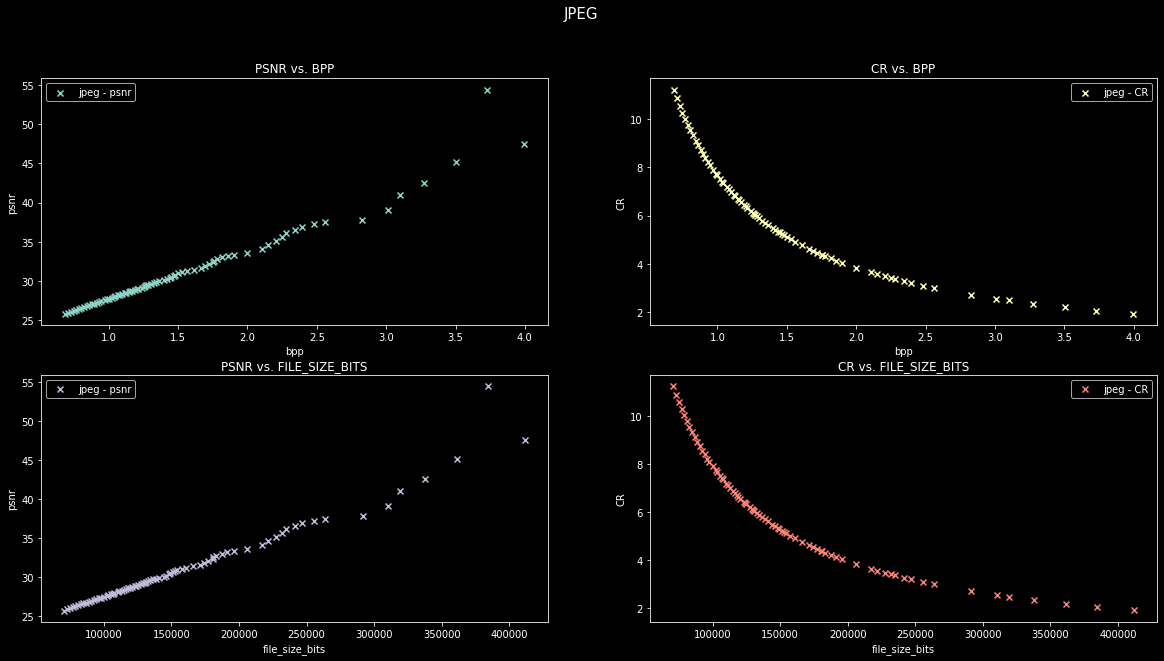

In [15]:
x_axes = "bpp;file_size_bits".split(";")
y_axes = "psnr;CR".split(";")

fig, axes = compute_graph_image_psnr_CR(
    data_tuples = result_tuples,
    x_axes = x_axes,
    y_axes = y_axes,
    subject = 'jpeg',
    colors = sns.color_palette())
fig.suptitle(f'JPEG', fontsize=15)
# plt.savefig('complex_plot_jpge_res.png')
plt.show()

In [16]:
x = np.arange(0, len(result_tuples), dtype=np.int)
y = np.array(list(map(lambda item: getattr(item, "psnr"), result_tuples)))

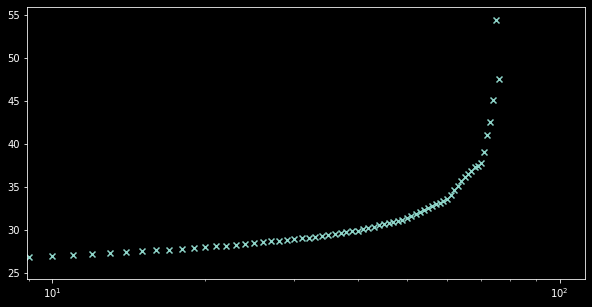

In [17]:
fig = plt.figure(figsize = (10, 5))
plt.scatter(x, y, marker = 'x')
plt.xscale('log')
plt.show()

In [18]:
model = LinearRegression()
model.fit(x.reshape(-1, 1), y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [19]:
 y_pred = model.predict(x.reshape(-1, 1))

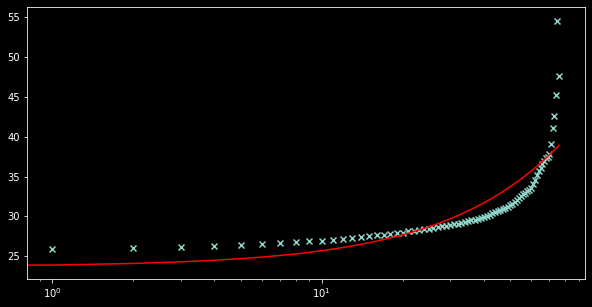

In [20]:
fig = plt.figure(figsize = (10, 5))
plt.plot(x, y_pred, color = 'red')
plt.scatter(x, y, marker = 'x')
plt.xscale('log')
plt.show()

In [21]:
transformer = PolynomialFeatures(degree=4, include_bias=False)

In [22]:
transformer.fit(x.reshape((-1, 1)))
x_ = transformer.transform(x.reshape((-1, 1)))

In [23]:
model = LinearRegression().fit(x_, y)

In [24]:
 y_pred_ = model.predict(x_)

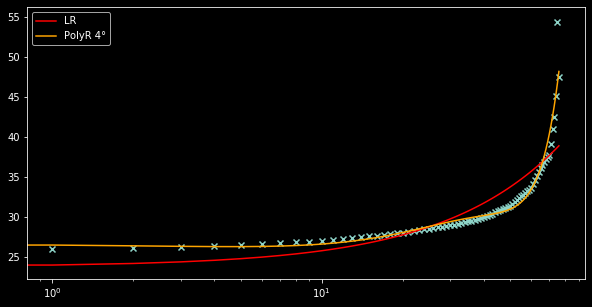

In [25]:
fig = plt.figure(figsize = (10, 5))
plt.plot(x, y_pred, color = 'red', label = 'LR')
plt.plot(x, y_pred_, color = 'orange', label = 'PolyR 4°')
plt.scatter(x, y, marker = 'x')
plt.xscale('log')
plt.legend()
plt.show()

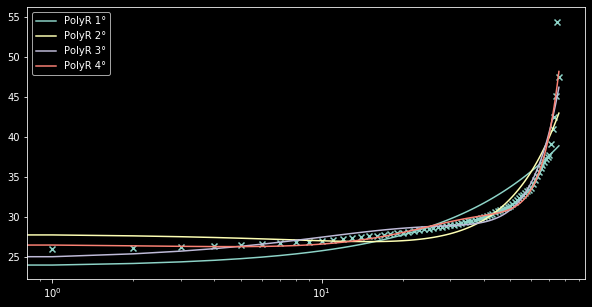

In [26]:
fig = plt.figure(figsize = (10, 5))

for degree in np.arange(1, 5):
    transformer = PolynomialFeatures(degree=degree, include_bias=False)
    
    transformer.fit(x.reshape((-1, 1)))
    x_ = transformer.transform(x.reshape((-1, 1)))
    
    model = LinearRegression().fit(x_, y)
    y_pred_ = model.predict(x_)
    plt.plot(x, y_pred_, label = f'PolyR {degree}°')
    pass
plt.scatter(x, y, marker = 'x')
plt.xscale('log')
plt.legend()
plt.show()

### References
- Real Python Tutorials
  - [Linear Regression in Python](https://realpython.com/linear-regression-in-python/)
  
- Matlab
  - [PSNR](https://www.mathworks.com/help/vision/ref/psnr.html)